In [176]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


from keras.engine.topology import Layer
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

class Dummy(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Dummy, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Dummy, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    [z_mean_1, z_log_var_1, z_mean_2, z_log_var_2, z_1, z_2, predict_c] = encoder.predict(x_test,batch_size=batch_size)
    
    color = np.ones(1000)
    for i in range(0, 1000):
        if predict_c[i] < 0.5:
            z_mean_1[i,:] = z_mean_2[i,:]
            color[i] = 0
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean_1[:, 0], z_mean_1[:, 1], c=color)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

In [177]:
original_dim = 8
mean1 = np.zeros(8)
mean2 = np.zeros(8)
mean2[0] = 1
mean2[1] = 1

cov1 = np.diag(np.ones(8))*0.001
cov2 = cov1
cov1[0,0] = 0.2
cov1[1,1] = 0.1
cov2[0,0] = 0.1
cov2[1,1] = 0.2

x1 = np.random.multivariate_normal(mean1, cov1, 500)
x2 = np.random.multivariate_normal(mean2, cov2, 500)
x_train = np.concatenate((x1,x2), axis = 0)

x1 = np.random.multivariate_normal(mean1, cov1, 500)
x2 = np.random.multivariate_normal(mean2, cov2, 500)
x_test = np.concatenate((x1,x2), axis = 0)
y_test = np.zeros(1000)
y_test[500:] = 1

In [183]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 4
batch_size = 64
latent_dim = 2
cat_dim = 1
epochs = 500

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
dummy = Input(shape=(latent_dim,), name='dummy')

mu1 = Dense(latent_dim, name='mu1')(dummy)
mu2 = Dense(latent_dim, name='mu2')(dummy)

# x = Dense(intermediate_dim)(inputs)

z_mean_1 = Dense(latent_dim, name='z_mean_1')(inputs)
z_log_var_1 = Dense(latent_dim, name='z_log_var_1')(inputs)
z_mean_2 = Dense(latent_dim, name='z_mean_2')(inputs)
z_log_var_2 = Dense(latent_dim, name='z_log_var_2')(inputs)

c = Dense(cat_dim, activation='sigmoid')(inputs)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z_1 = Lambda(sampling, output_shape=(latent_dim,), name='z_1')([z_mean_1, z_log_var_1])
z_2 = Lambda(sampling, output_shape=(latent_dim,), name='z_2')([z_mean_2, z_log_var_2])

# instantiate encoder model
encoder = Model([inputs,dummy], [z_mean_1, z_log_var_1, z_mean_2, z_log_var_2, z_1, z_2, c, mu1, mu2], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs_1 = Input(shape=(latent_dim,), name='z_sampling_1')
#x_1 = Dense(intermediate_dim)(latent_inputs_1)
outputs_1 = Dense(original_dim)(latent_inputs_1)

latent_inputs_2 = Input(shape=(latent_dim,), name='z_sampling_2')
#x_2 = Dense(intermediate_dim)(latent_inputs_2)
outputs_2 = Dense(original_dim)(latent_inputs_2)

# instantiate decoder model
decoder = Model([latent_inputs_1, latent_inputs_2], [outputs_1, outputs_2], name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
[outputs_1, outputs_2] = decoder(encoder([inputs,dummy])[4:6])
vae = Model([inputs,dummy], [outputs_1, outputs_2], name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 8)            0                                            
__________________________________________________________________________________________________
z_mean_1 (Dense)                (None, 2)            18          encoder_input[0][0]              
__________________________________________________________________________________________________
z_log_var_1 (Dense)             (None, 2)            18          encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean_2 (Dense)                (None, 2)            18          encoder_input[0][0]              
__________________________________________________________________________________________________
z_log_var_

In [184]:
#if __name__ == '__main__':
#    parser = argparse.ArgumentParser()
#    help_ = "Load h5 model trained weights"
#    parser.add_argument("-w", "--weights", help=help_)
#    help_ = "Use mse loss instead of binary cross entropy (default)"
#    parser.add_argument("-m",
#                        "--mse",
#                        help=help_, action='store_true')
#    args = parser.parse_args()
dummy = np.ones((1000,2))

models = (encoder, decoder)
    #data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
#    if args.mse:
reconstruction_loss_1 = mse(inputs, outputs_1)
reconstruction_loss_2 = mse(inputs, outputs_2)
#    else:
#        reconstruction_loss = binary_crossentropy(inputs,
#                                                  outputs)

reconstruction_loss_1 *= original_dim * c
reconstruction_loss_2 *= original_dim * (1-c)

kl_loss_1 = 1 + z_log_var_1 - K.square(z_mean_1 - mu1) - K.exp(z_log_var_1)
kl_loss_1 = K.sum(kl_loss_1, axis=-1)
kl_loss_1 *= -0.5 * c

kl_loss_2 = 1 + z_log_var_2 - K.square(z_mean_2 - mu2) - K.exp(z_log_var_2)
kl_loss_2 = K.sum(kl_loss_2, axis=-1)
kl_loss_2 *= -0.5 * (1-c)

vae_loss = K.mean(reconstruction_loss_1 + reconstruction_loss_2 + kl_loss_1 + kl_loss_2 + c * K.log(c) + (1-c) * K.log(1-c)) 

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
#    plot_model(vae,
#               to_file='vae_mlp.png',
#               show_shapes=True)

#    if args.weights:
#        vae.load_weights(args.weights)
#    else:
        # train the autoencoder
vae.fit([x_train,dummy],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,dummy], None))
vae.save_weights('vae_mlp_mnist.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 8)            0                                            
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 93          encoder_input[0][0]              
                                                                 dummy[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 [(None, 8), (None, 8 48          encoder[1][4]                    
          

1000/1000 [==============================] - 0s 181us/step - loss: 0.1272 - val_loss: 0.1583
Epoch 65/500
1000/1000 [==============================] - 0s 162us/step - loss: 0.1503 - val_loss: 0.1300
Epoch 66/500
1000/1000 [==============================] - 0s 138us/step - loss: 0.1259 - val_loss: 0.1364
Epoch 67/500
1000/1000 [==============================] - 0s 129us/step - loss: 0.1271 - val_loss: 0.1385
Epoch 68/500
1000/1000 [==============================] - 0s 115us/step - loss: 0.1193 - val_loss: 0.1240
Epoch 69/500
1000/1000 [==============================] - 0s 123us/step - loss: 0.1201 - val_loss: 0.1193
Epoch 70/500
1000/1000 [==============================] - 0s 131us/step - loss: 0.1110 - val_loss: 0.1349
Epoch 71/500
1000/1000 [==============================] - 0s 132us/step - loss: 0.1012 - val_loss: 0.1084
Epoch 72/500
1000/1000 [==============================] - 0s 128us/step - loss: 0.1083 - val_loss: 0.1214
Epoch 73/500
1000/1000 [==============================] - 0

1000/1000 [==============================] - 0s 113us/step - loss: 0.0842 - val_loss: 0.0891
Epoch 142/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0763 - val_loss: 0.0941
Epoch 143/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0803 - val_loss: 0.0816
Epoch 144/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0669 - val_loss: 0.0894
Epoch 145/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0694 - val_loss: 0.0800
Epoch 146/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0836 - val_loss: 0.1083
Epoch 147/500
1000/1000 [==============================] - 0s 106us/step - loss: 0.0688 - val_loss: 0.0917
Epoch 148/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0700 - val_loss: 0.0962
Epoch 149/500
1000/1000 [==============================] - 0s 106us/step - loss: 0.0769 - val_loss: 0.0862
Epoch 150/500
1000/1000 [==========================

1000/1000 [==============================] - 0s 106us/step - loss: 0.0645 - val_loss: 0.1005
Epoch 218/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0912 - val_loss: 0.0900
Epoch 219/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0766 - val_loss: 0.0944
Epoch 220/500
1000/1000 [==============================] - 0s 103us/step - loss: 0.0672 - val_loss: 0.1040
Epoch 221/500
1000/1000 [==============================] - 0s 126us/step - loss: 0.0942 - val_loss: 0.0969
Epoch 222/500
1000/1000 [==============================] - 0s 123us/step - loss: 0.0830 - val_loss: 0.0749
Epoch 223/500
1000/1000 [==============================] - 0s 111us/step - loss: 0.0771 - val_loss: 0.0792
Epoch 224/500
1000/1000 [==============================] - 0s 106us/step - loss: 0.0733 - val_loss: 0.0930
Epoch 225/500
1000/1000 [==============================] - 0s 108us/step - loss: 0.0684 - val_loss: 0.0959
Epoch 226/500
1000/1000 [==========================

1000/1000 [==============================] - 0s 105us/step - loss: 0.0646 - val_loss: 0.0860
Epoch 294/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0623 - val_loss: 0.0712
Epoch 295/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0697 - val_loss: 0.0919
Epoch 296/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0784 - val_loss: 0.0829
Epoch 297/500
1000/1000 [==============================] - 0s 107us/step - loss: 0.0800 - val_loss: 0.0874
Epoch 298/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0876 - val_loss: 0.0876
Epoch 299/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0618 - val_loss: 0.0753
Epoch 300/500
1000/1000 [==============================] - 0s 107us/step - loss: 0.0671 - val_loss: 0.0902
Epoch 301/500
1000/1000 [==============================] - 0s 106us/step - loss: 0.0870 - val_loss: 0.0837
Epoch 302/500
1000/1000 [==========================

1000/1000 [==============================] - 0s 104us/step - loss: 0.0863 - val_loss: 0.0806
Epoch 370/500
1000/1000 [==============================] - 0s 103us/step - loss: 0.0666 - val_loss: 0.0868
Epoch 371/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0759 - val_loss: 0.0767
Epoch 372/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0707 - val_loss: 0.0646
Epoch 373/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0661 - val_loss: 0.0717
Epoch 374/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0651 - val_loss: 0.0848
Epoch 375/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0880 - val_loss: 0.0957
Epoch 376/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0802 - val_loss: 0.0875
Epoch 377/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0678 - val_loss: 0.0862
Epoch 378/500
1000/1000 [==========================

1000/1000 [==============================] - 0s 103us/step - loss: 0.0904 - val_loss: 0.0821
Epoch 446/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0971 - val_loss: 0.0695
Epoch 447/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0671 - val_loss: 0.0715
Epoch 448/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0722 - val_loss: 0.0863
Epoch 449/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0626 - val_loss: 0.0820
Epoch 450/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0762 - val_loss: 0.0860
Epoch 451/500
1000/1000 [==============================] - 0s 104us/step - loss: 0.0758 - val_loss: 0.0821
Epoch 452/500
1000/1000 [==============================] - 0s 103us/step - loss: 0.0694 - val_loss: 0.0832
Epoch 453/500
1000/1000 [==============================] - 0s 103us/step - loss: 0.0806 - val_loss: 0.0587
Epoch 454/500
1000/1000 [==========================

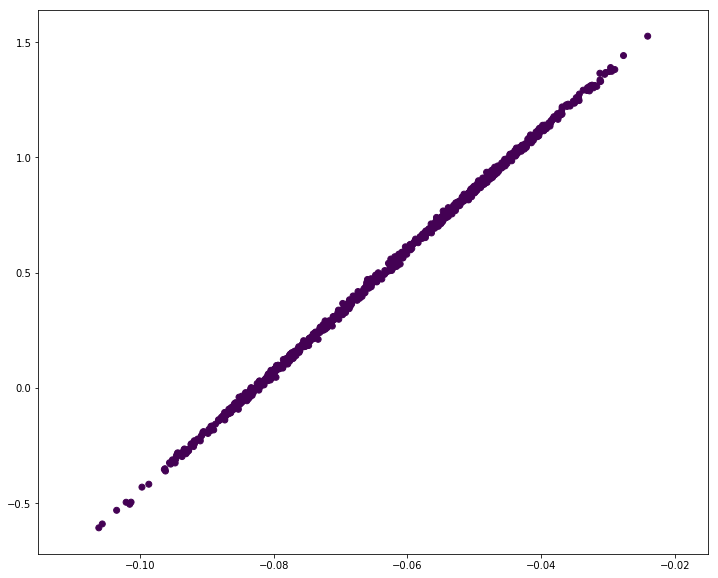

In [186]:
[z_mean_1, z_log_var_1, z_mean_2, z_log_var_2, z_1, z_2, predict_c, mu1, mu2] = encoder.predict([x_test,dummy],batch_size=batch_size)
color = np.ones(1000)
for i in range(0, 1000):
    if predict_c[i] < 0.5:
        z_mean_1[i,:] = z_mean_2[i,:]
        color[i] = 0
plt.figure(figsize=(12, 10))
plt.scatter(z_mean_1[:, 0], z_mean_1[:, 1], c=color)

In [182]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.